## PURPOSE OF THE NOTEBOOK
The aim of this notebook is to define vessels present in the GB sections and define size, structure and composition of them

# Import all libraries & functions needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import scanpy as sc
import os 
import seaborn as sns
import networkx as nx
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from tqdm import tqdm
import scipy.stats as scpst
import numpy as np
from shapely.geometry import Point, Polygon


In [2]:
def connected_components(neighbors):
    seen = set()
    def component(node):
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            seen.add(node)
            nodes |= neighbors[node] - seen
            yield node
    for node in neighbors:
        if node not in seen:
            yield component(node)
def getRoots(aNeigh):
    def findRoot(aNode,aRoot):
        while aNode != aRoot[aNode][0]:
            aNode = aRoot[aNode][0]
        return (aNode,aRoot[aNode][1])
    myRoot = {} 
    for myNode in aNeigh.keys():
        myRoot[myNode] = (myNode,0)  
    for myI in aNeigh: 
        for myJ in aNeigh[myI]: 
            try:
                (myRoot_myI,myDepthMyI) = findRoot(myI,myRoot) 
                (myRoot_myJ,myDepthMyJ) = findRoot(myJ,myRoot) 
                if myRoot_myI != myRoot_myJ: 
                    myMin = myRoot_myI
                    myMax = myRoot_myJ 
                    if  myDepthMyI > myDepthMyJ: 
                        myMin = myRoot_myJ
                        myMax = myRoot_myI
                    myRoot[myMax] = (myMax,max(myRoot[myMin][1]+1,myRoot[myMax][1]))
                    myRoot[myMin] = (myRoot[myMax][0],-1) 
            except:
                sss=2
    myToRet = {}
    for myI in aNeigh: 
        if myRoot[myI][0] == myI:
            myToRet[myI] = []
    for myI in aNeigh: 
        myToRet[findRoot(myI,myRoot)[0]].append(myI) 
    return myToRet  

# first we load the dataset

In [3]:
def define_basal_apical(path,reg,memb):
    EPI=pd.read_csv(path+reg)
    json_feat=pd.read_json(path+memb)
    coords=pd.DataFrame(json_feat['features'][0]['geometry']['coordinates'][0][0])
    coords.columns=['x','y']
    plt.scatter(EPI['xc'],EPI['yc'])
    plt.scatter(coords['x'],coords['y'])
    from tqdm import tqdm
    allp=[]
    for e in tqdm(EPI.index):
        xp=EPI.loc[e,'xc']
        yp=EPI.loc[e,'yc']
        meas=((coords['x']-xp)**2)+((coords['y']-yp)**2)
        allp.append(meas.min())
    EPI['basal_dist']=np.sqrt(allp)
    #EPI['basal_dist']=EPI['basal_dist'].round(-1)
    maxpc=np.percentile(EPI['basal_dist'],95)
    EPI['basal_dist'][EPI['basal_dist']>maxpc]=maxpc
    EPI['basal_dist']=EPI['basal_dist']/maxpc
    EPI['basal_dist']=EPI['basal_dist'].round(1)
    plt.scatter(EPI['xc'],EPI['yc'],c=EPI['basal_dist'],s=1)
    exp=pd.crosstab(EPI['target'],EPI['basal_dist'])
    #REMOVE THIS LINE TO NOT NORMALIZE BY THE SIZE OF THE EPITHELIUM
    return exp,EPI

def define_basal_apical(path,region,memb,cellt):
    try:
        EPI=pd.read_json(path+region)
        pol=Polygon(EPI['features'][0]['geometry']['coordinates'][0][0])
        binary=[]
    except:
        EPI=pd.read_csv(path+region)
        pol=Polygon(EPI['features'][0]['geometry']['coordinates'][0][0])
        binary=[]
    for e in cellt.obs.index:
        xp=cellt.obs.loc[e,'X']
        yp=cellt.obs.loc[e,'Y']
        madepoint=Point(xp,yp)
        binary.append(pol.contains(madepoint))
    cellt.obs['in_epi']=binary
    EPIC=cellt[cellt.obs['in_epi']]
    json_feat=pd.read_json(path+memb)
    coords=pd.DataFrame(json_feat['features'][0]['geometry']['coordinates'][0][0])
    coords.columns=['x','y']
    plt.scatter(EPIC.obs['X'],EPIC.obs['Y'])
    plt.scatter(coords['x'],coords['y'])
    from tqdm import tqdm
    allp=[]
    for e in tqdm(EPIC.obs.index):
        xp=EPIC.obs.loc[e,'X']
        yp=EPIC.obs.loc[e,'Y']
        meas=((coords['x']-xp)**2)+((coords['y']-yp)**2)
        allp.append(meas.min())
    EPIC.obs['basal_dist']=np.sqrt(allp)
    #EPI['basal_dist']=EPI['basal_dist'].round(-1)
    maxpc=np.percentile(EPIC.obs['basal_dist'],95)
    EPIC.obs['basal_dist'][EPIC.obs['basal_dist']>maxpc]=maxpc
    EPIC.obs['basal_dist']=EPIC.obs['basal_dist']/maxpc
    EPIC.obs['basal_dist_norm']=EPIC.obs['basal_dist'].round(1)
    plt.scatter(EPIC.obs['X'],EPIC.obs['Y'],c=EPIC.obs['basal_dist'],s=1)
    exp=pd.crosstab(EPIC.obs['celltype_annotated_general'],EPIC.obs['basal_dist_norm'])
    #REMOVE THIS LINE TO NOT NORMALIZE BY THE SIZE OF THE EPITHELIUM
    gorder=EPIC.obs.loc[:,['celltype_annotated_general','basal_dist_norm']].groupby('celltype_annotated_general').median().sort_values(by='basal_dist_norm',ascending=True).index
    exp=exp.loc[gorder,:]
    selg=EPIC.obs.loc[:,['celltype_annotated_general','basal_dist_norm']].groupby('celltype_annotated_general').count().sort_values(by='basal_dist_norm',ascending=False)
    #expsort=exp.loc[exp.index.isin(selg.index[0:40]),:]

    return exp,EPIC

In [4]:
adata=sc.read('/Users/sergio/Downloads/adata_16samples_clustered_log_annotated_curated_notln_adata4_211123_with_colors_&refined.h5ad')

100%|██████████| 3989/3989 [00:00<00:00, 10464.73it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

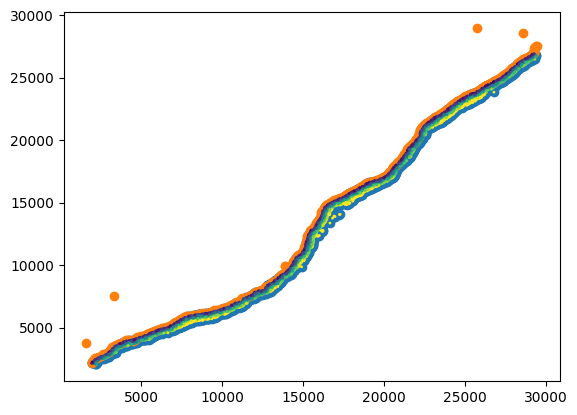

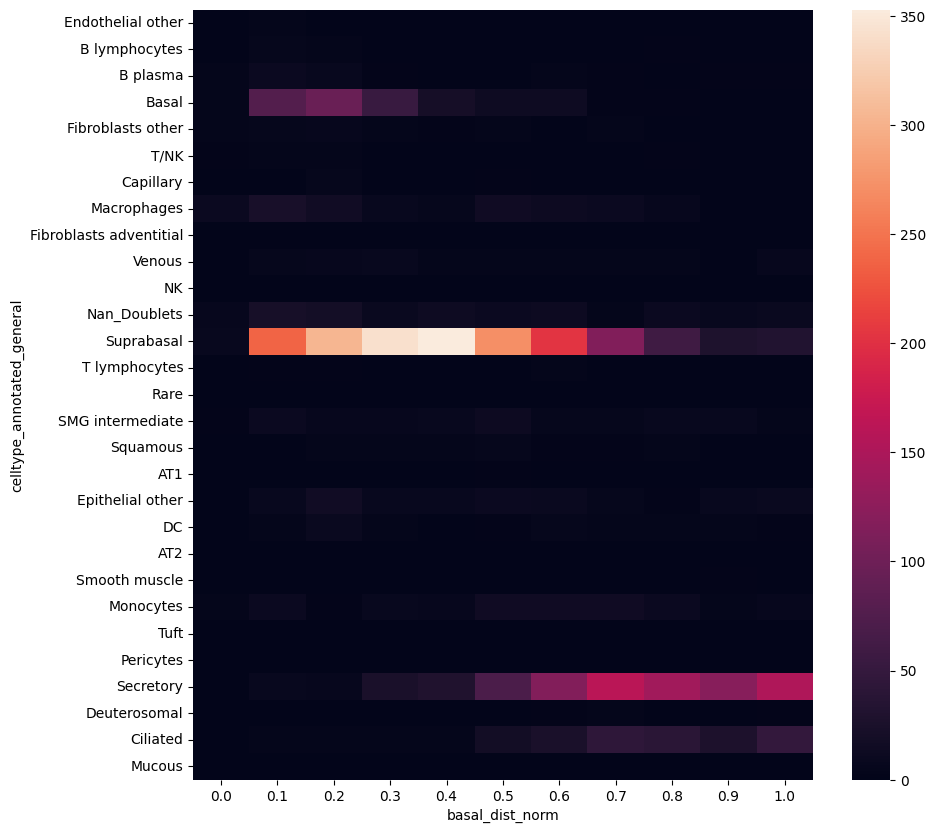

In [5]:
cellt=adata[adata.obs['sample']=='640C_LNG2'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='640C_LNG2_epithelium.json'
memb='640C_LNG2_basal_membrane.json'
exp640C_LNG2,EPI640C_LNG2=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp640C_LNG2)#_640C_LNG2)

100%|██████████| 2271/2271 [00:00<00:00, 10451.80it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

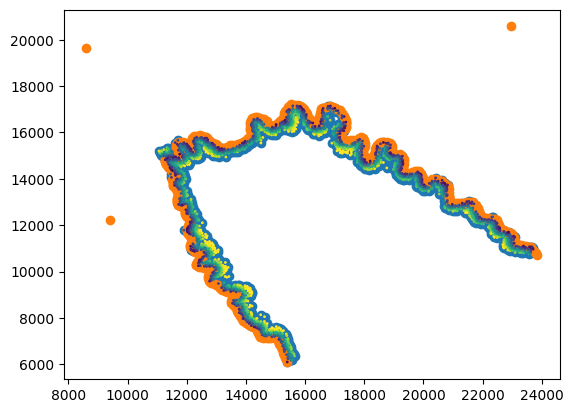

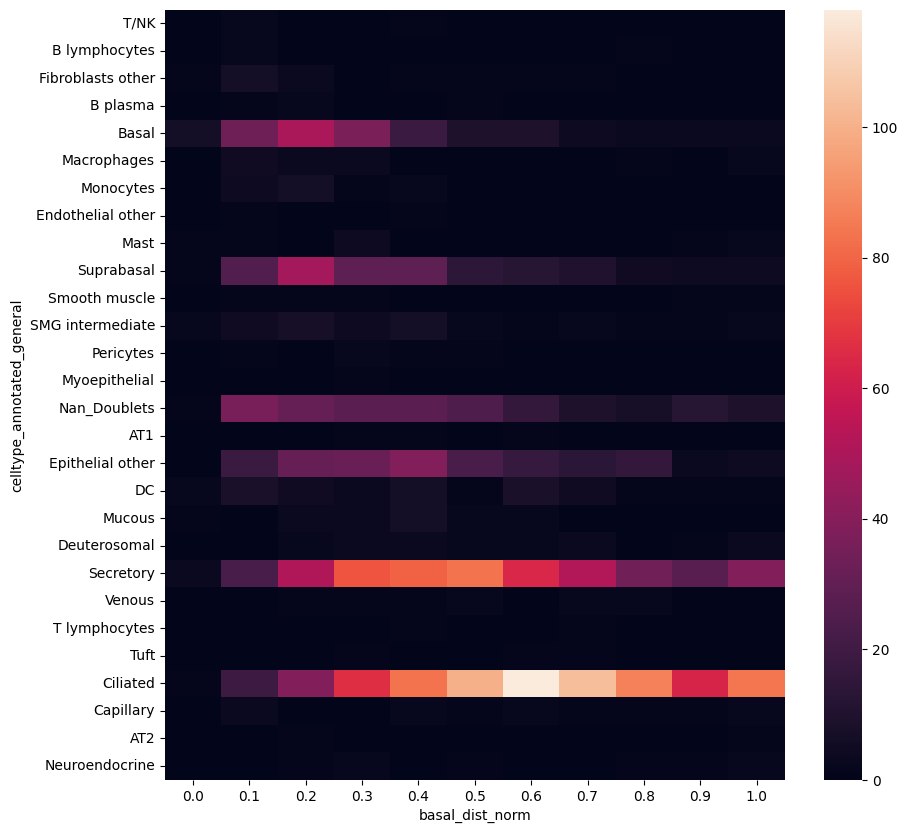

In [6]:
cellt=adata[adata.obs['sample']=='640C_LNG3'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='640C_LNG3_epithelium..json'
regionepi='640C_LNG3_epithelium.csv'
memb='640C_LNG3_basal_membrane..json'
exp640C_LNG3,EPI640C_LNG3=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp640C_LNG3)#_640C_LNG2)

100%|██████████| 586/586 [00:00<00:00, 10775.18it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

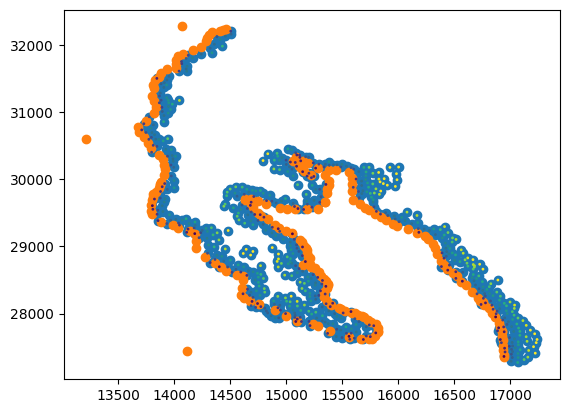

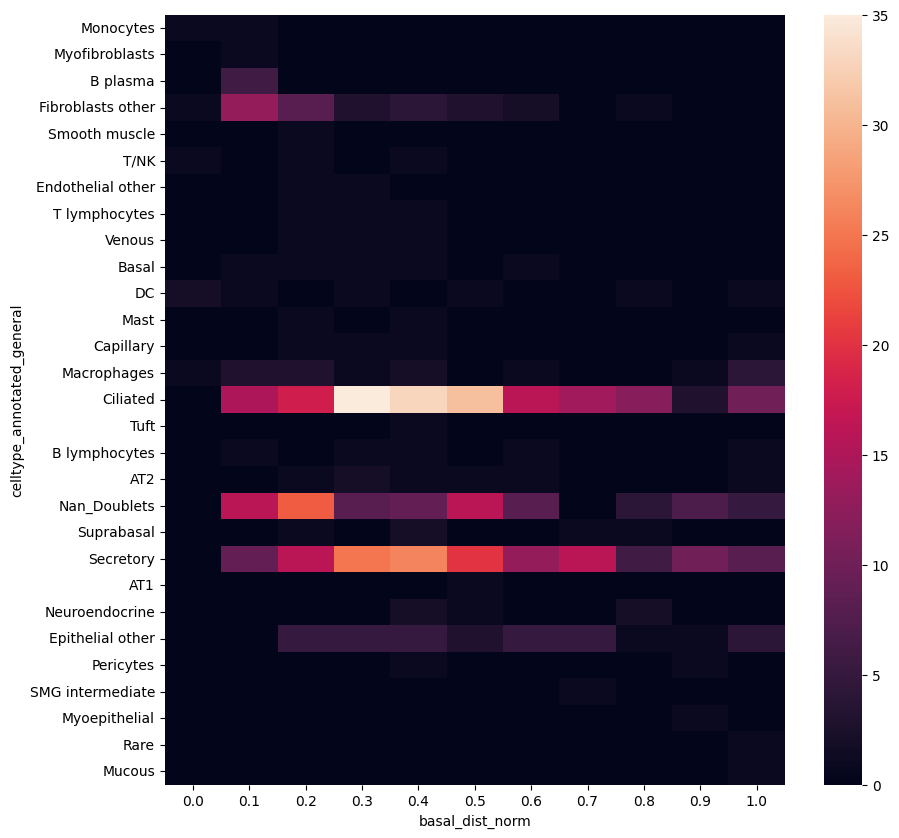

In [7]:
cellt=adata[adata.obs['sample']=='640C_LNG5'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='640C_LNG5_epithelium..json'
memb='640C_LNG5_basal_membrane..json'
exp640C_LNG5,EPI640C_LNG5=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp640C_LNG5)#_640C_LNG2)

100%|██████████| 4148/4148 [00:00<00:00, 9863.76it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

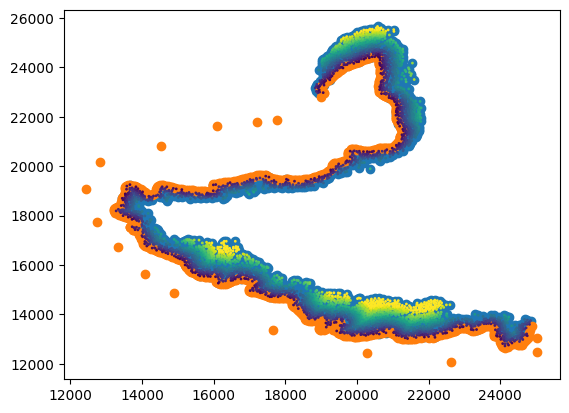

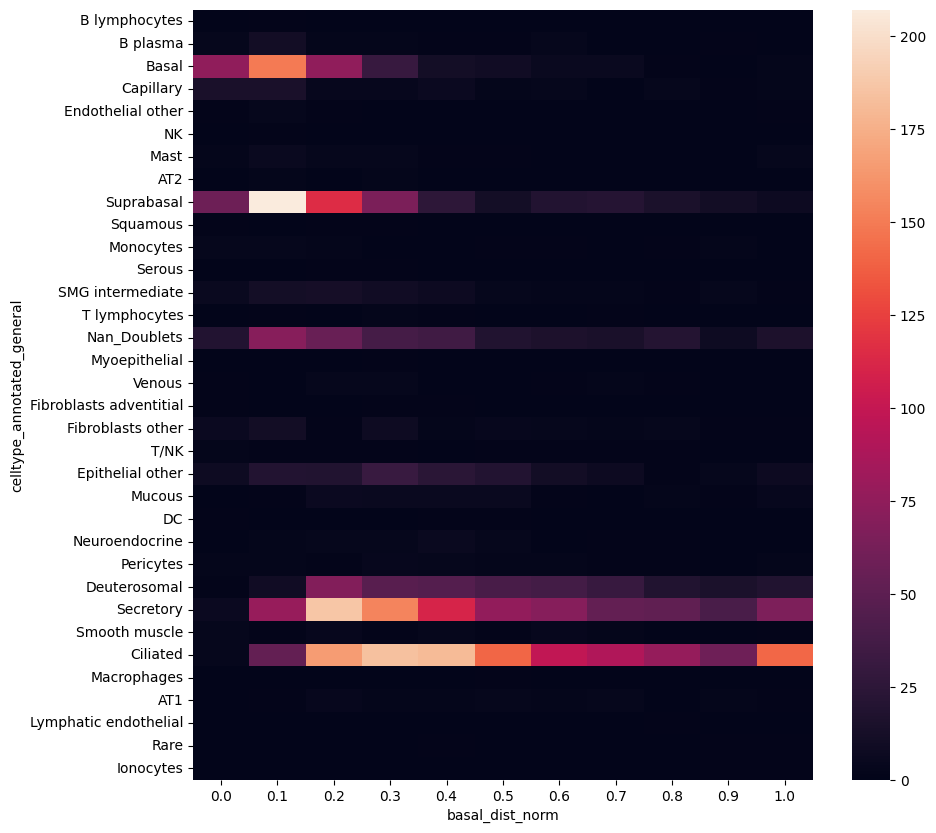

In [8]:
cellt=adata[adata.obs['sample']=='583B_LNG2'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='583_LNG2_epithelium..json'
memb='583_LNG2_basal_membrane..json'
exp583_LNG2,EPI583_LNG2=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp583_LNG2)#_640C_LNG2)

100%|██████████| 325/325 [00:00<00:00, 10748.10it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

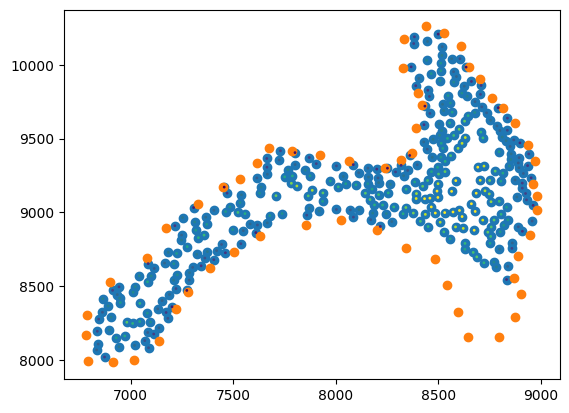

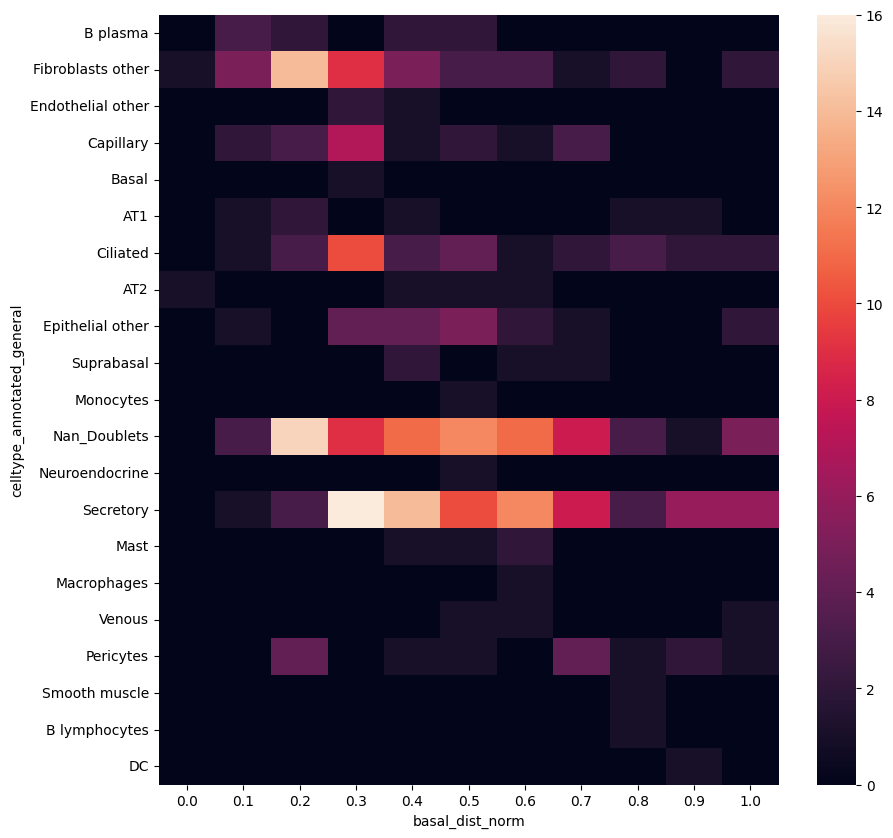

In [9]:
cellt=adata[adata.obs['sample']=='588B2_LNG1'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='588_LNG1_epithelium..json'
memb='588_LNG1_basal_membrane..json'
exp588_LNG1,EPI588_LNG1=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp588_LNG1)#_640C_LNG2)

100%|██████████| 1417/1417 [00:00<00:00, 9879.60it/s] 


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

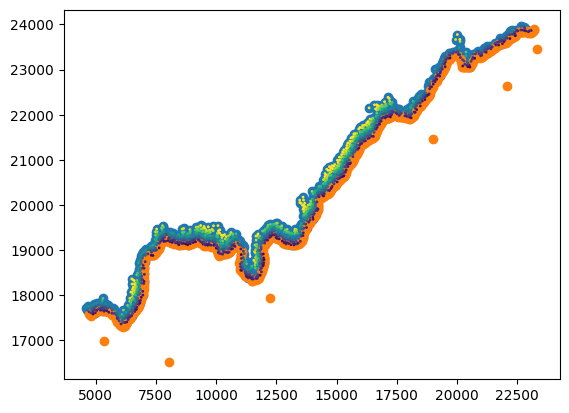

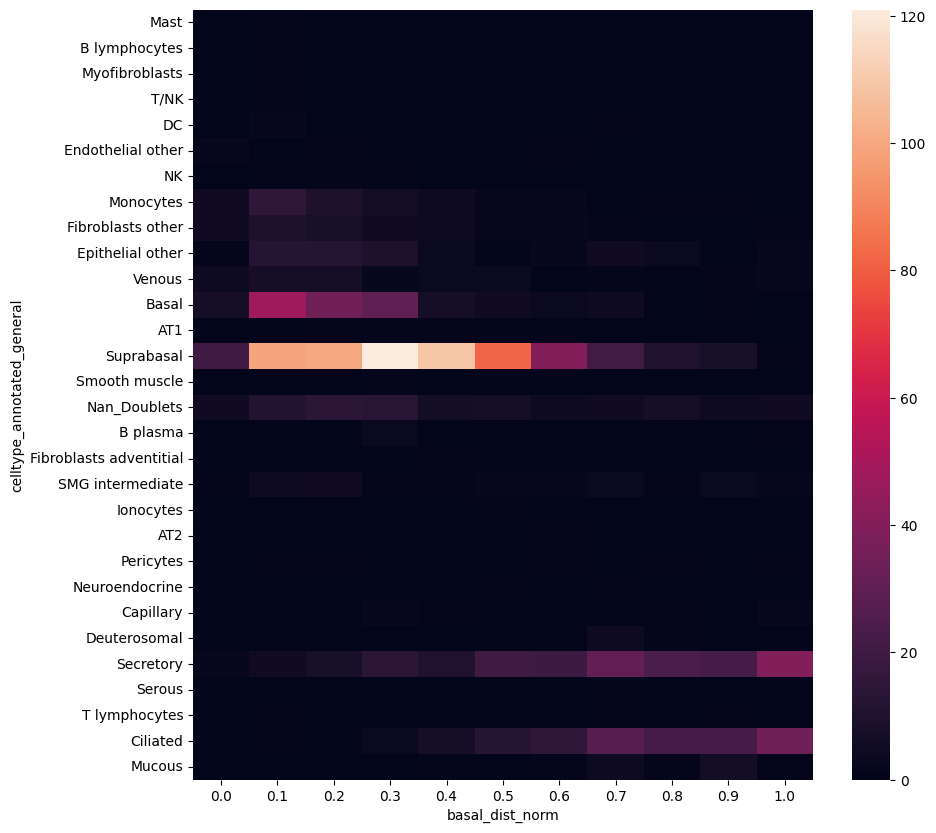

In [10]:
cellt=adata[adata.obs['sample']=='588B_LNG2'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='588_LNG2_epithelium..json'
memb='588_LNG2_basal_membrane..json'
exp588_LNG2,EPI588_LNG2=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp588_LNG2)#_640C_LNG2)

100%|██████████| 317/317 [00:00<00:00, 11240.31it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

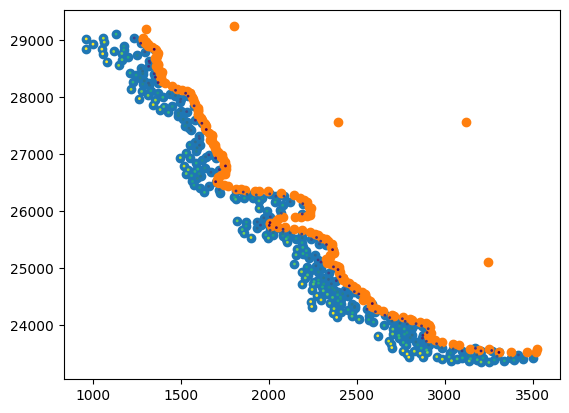

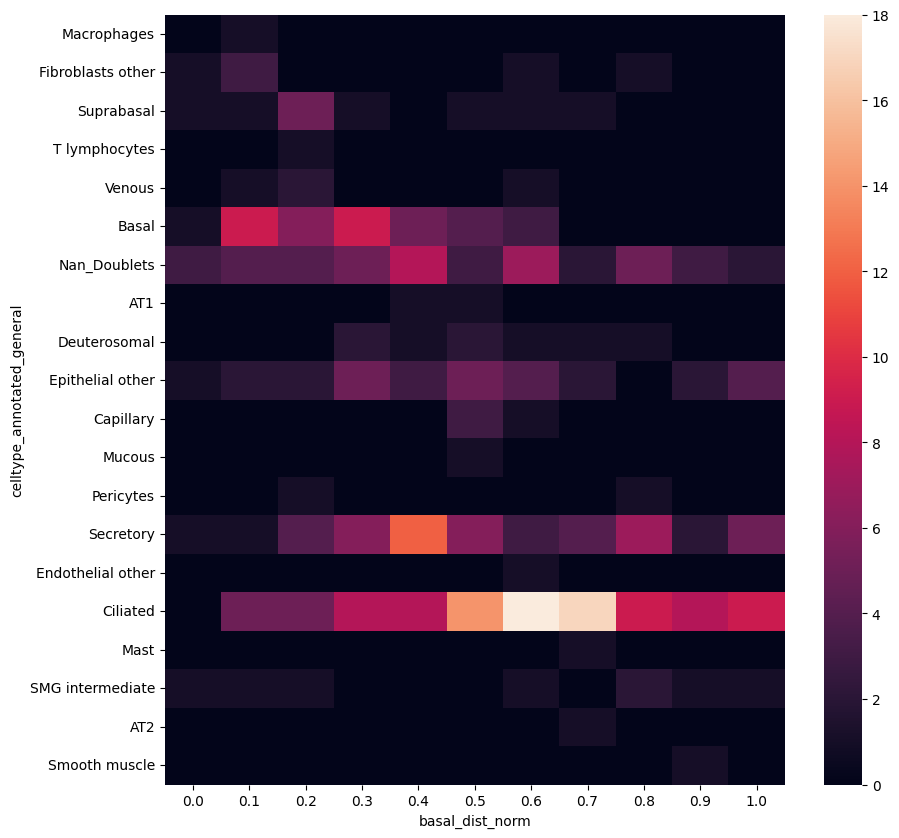

In [11]:
cellt=adata[adata.obs['sample']=='588B1_LNG3'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='588_LNG3_epithelium..json'
memb='588_LNG3_basal_membrane..json'
exp588_LNG3,EPI588_LNG3=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp588_LNG3)#_640C_LNG2)

100%|██████████| 377/377 [00:00<00:00, 10603.61it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

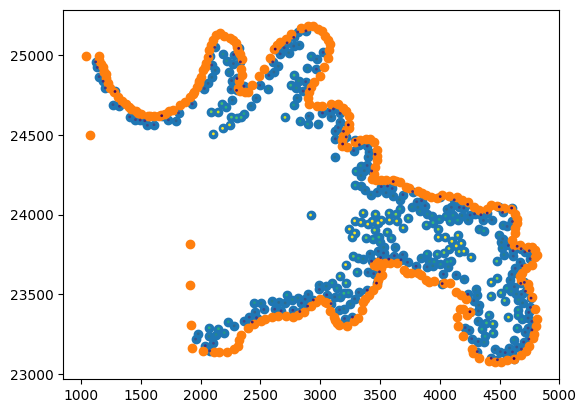

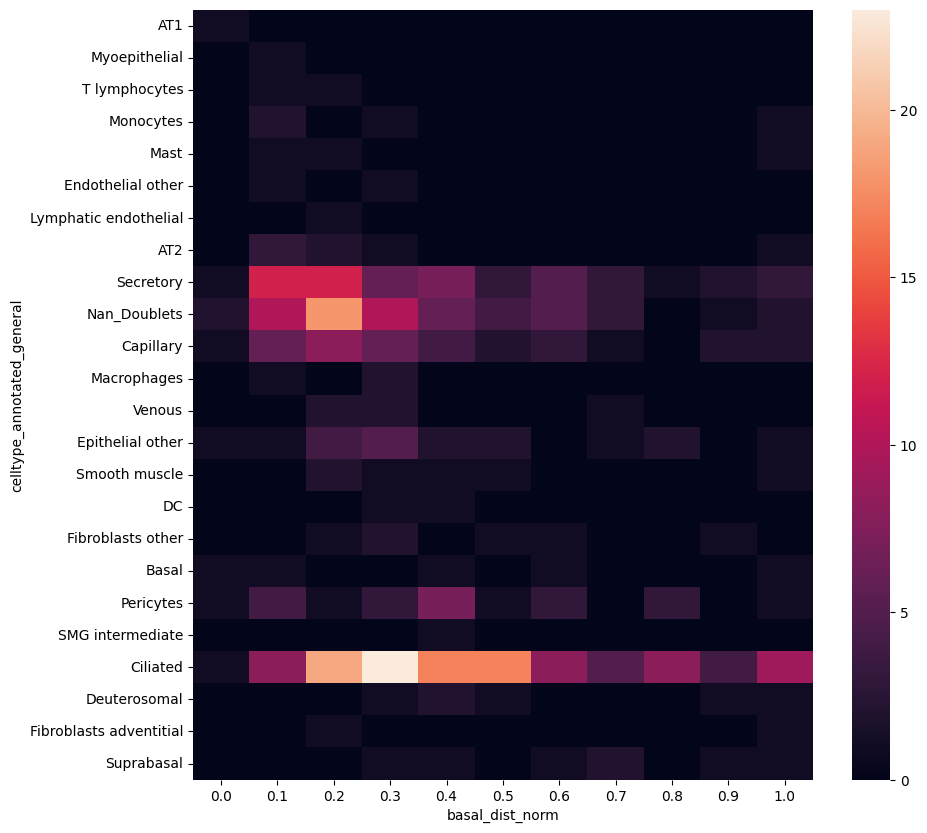

In [12]:
cellt=adata[adata.obs['sample']=='588B_LNG6'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='588_LNG6_epithelium..json'
memb='588_LNG6_basal_membrane..json'
exp588_LNG6,EPI588_LNG6=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp588_LNG6)#_640C_LNG2)

100%|██████████| 342/342 [00:00<00:00, 11163.31it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

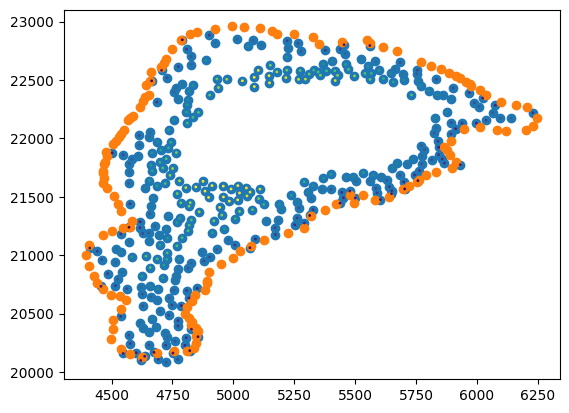

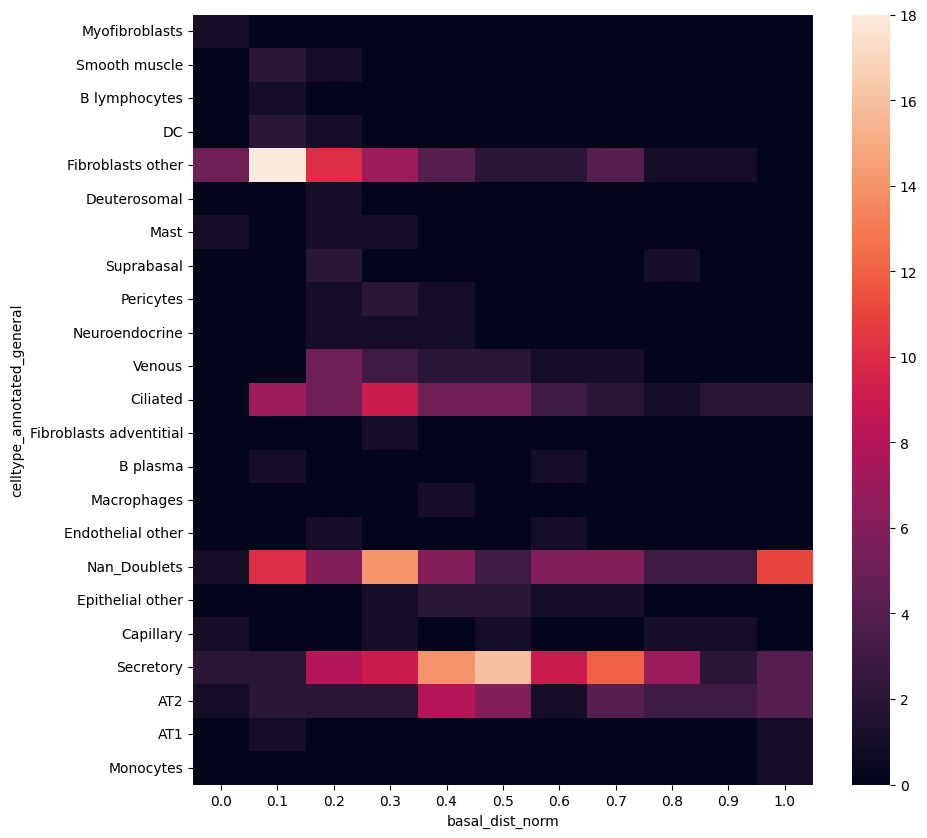

In [14]:
cellt=adata[adata.obs['sample']=='689C_LNG1'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='689_LNG1_epithelium..json'
memb='689_LNG1_basal_membrane..json'
exp689_LNG1,EPI689_LNG1=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp689_LNG1)#_640C_LNG2)

100%|██████████| 3267/3267 [00:00<00:00, 9956.46it/s] 


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

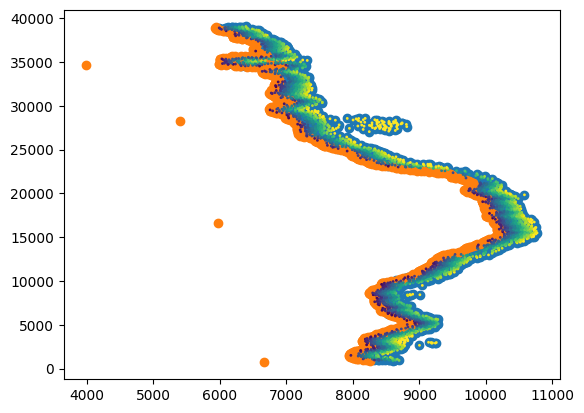

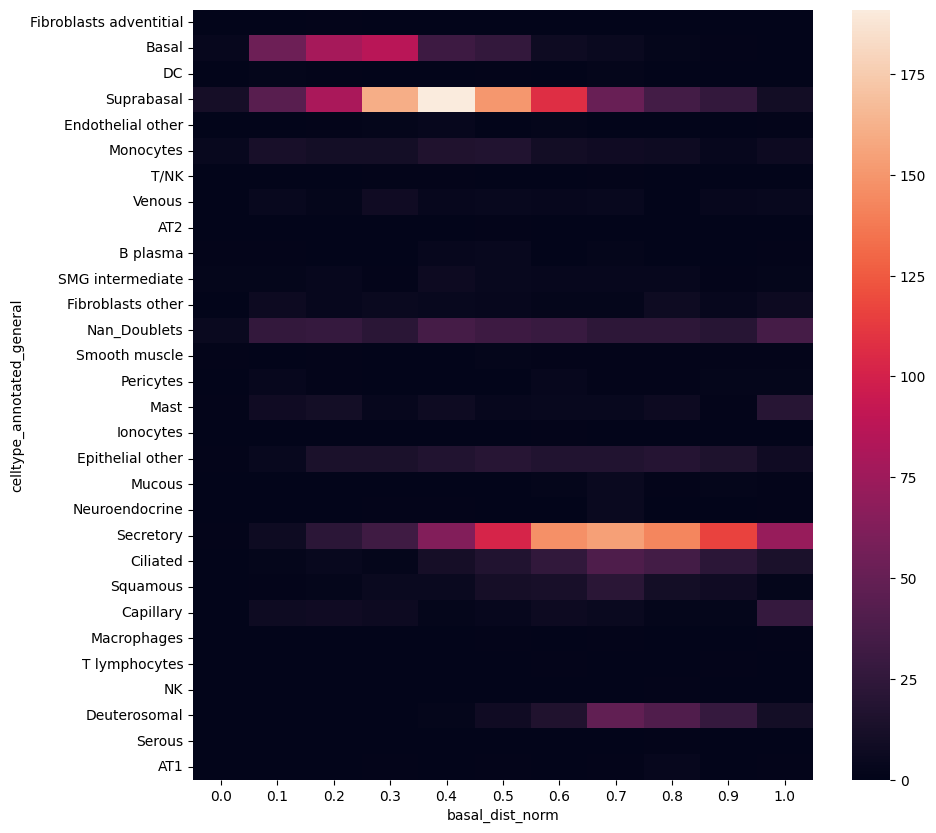

In [15]:
cellt=adata[adata.obs['sample']=='689C_LNG2'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='689_LNG2_epithelium..json'
memb='689_LNG2_basal_membrane..json'
exp689_LNG2,EPI689_LNG2=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp689_LNG2)#_640C_LNG2)

100%|██████████| 143/143 [00:00<00:00, 11666.94it/s]


<Axes: xlabel='basal_dist_norm', ylabel='celltype_annotated_general'>

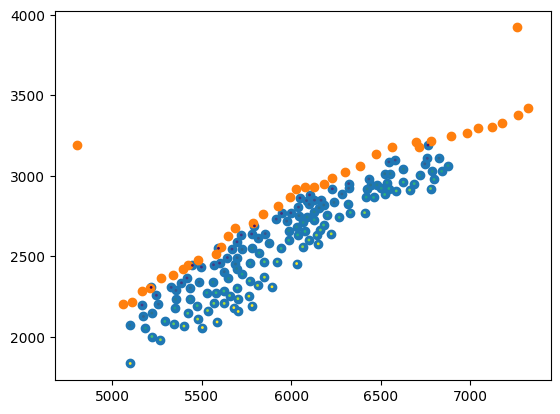

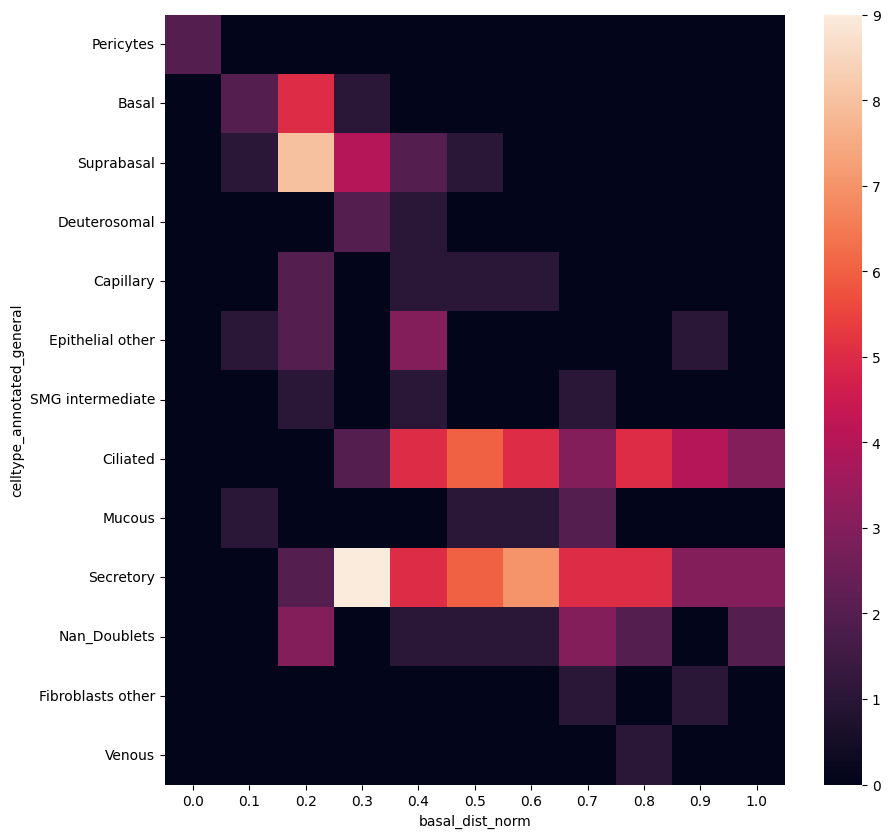

In [16]:
cellt=adata[adata.obs['sample']=='689C_LNG3'].copy()
path='/Users/sergio/Downloads/epithelial_region/'
region='689_LNG3_epithelium.json'
memb='689_LNG3_basal_membrane..json'
exp689_LNG3,EPI689_LNG3=define_basal_apical(path,region,memb,cellt)
plt.figure(figsize=(10,10))
sns.heatmap(exp689_LNG3)#_640C_LNG2)

# Comparing by global frequency

In [17]:
#640
counts640_LNG2=pd.DataFrame(np.sum(exp640C_LNG2,axis=1),columns=['640C_LNG2'])
counts640_LNG5=pd.DataFrame(np.sum(exp640C_LNG5,axis=1),columns=['640C_LNG5'])
counts640_LNG3=pd.DataFrame(np.sum(exp640C_LNG3,axis=1),columns=['640C_LNG3'])
#689
counts689_LNG2=pd.DataFrame(np.sum(exp689_LNG2,axis=1),columns=['689C_LNG2'])
counts689_LNG1=pd.DataFrame(np.sum(exp689_LNG1,axis=1),columns=['689C_LNG1'])
counts689_LNG3=pd.DataFrame(np.sum(exp689_LNG3,axis=1),columns=['689C_LNG3'])

#588
counts588_LNG2=pd.DataFrame(np.sum(exp588_LNG2,axis=1),columns=['588_LNG2'])
counts588_LNG1=pd.DataFrame(np.sum(exp588_LNG1,axis=1),columns=['588_LNG1'])
counts588_LNG3=pd.DataFrame(np.sum(exp588_LNG3,axis=1),columns=['588_LNG3'])


In [18]:
epith_expression=pd.concat([counts640_LNG2,counts640_LNG3,counts640_LNG5,counts689_LNG1,counts689_LNG2,counts689_LNG3,
                           counts588_LNG1,counts588_LNG2,counts588_LNG3],axis=1)

In [19]:
epith_expression=epith_expression.fillna(0)
#exx=epith_expression.div(np.sum(epith_expression,axis=0),axis=1)
#exxp=exx[exx.max(axis=1)>0.005]

In [20]:
epith_expression=epith_expression.loc[:,['640C_LNG5','689C_LNG1','588_LNG1',
                                         '640C_LNG3','689C_LNG3','588_LNG3',
    '640C_LNG2','689C_LNG2','588_LNG2']]
epith=[ 'Basal','Suprabasal', 'Rare', 'Squamous','Epithelial other', 'Tuft',
'Secretory', 'Deuterosomal', 'Ciliated', 'Neuroendocrine','Ionocytes']

In [21]:
epicell=epith_expression.loc[epith,:]
epicell=epicell.div(epicell.sum(axis=0),axis=1)

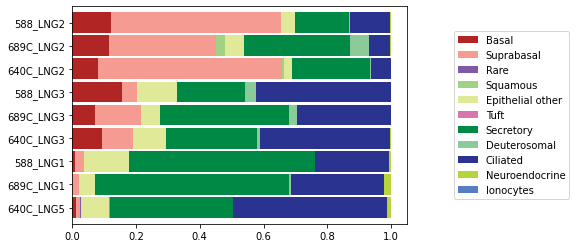

In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
epicell.transpose().plot(kind='barh',stacked=True,width=0.9,color=['#B22525','#F69B91','#815AA5','#A1D183','#DFE998',
                                                                   '#D974AE','#008944',
                                                                   '#8ACB99','#2A3390','#B7D43D','#557FC0'])
plt.legend(bbox_to_anchor=(1.5, 0.5),loc='right')

plt.savefig('/Users/sergio/Downloads/plots_for_publication/epithelium_analysis/barplot_epith_by_sample.pdf')
#plt.savefig('../../figures/celltype_identification_mscoronal/stacked_barplot_celltypes.pdf')

In [ ]:
plt.figure(figsize=(6,8))
sns.heatmap(epicell.div(epicell.sum(axis=0),axis=1),cmap='Blues')

# Comparison by structure

In [22]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
#640
counts640_LNG2=pd.DataFrame(np.std(exp640C_LNG2,axis=1),columns=['640C_LNG2'])
counts640_LNG5=pd.DataFrame(np.std(exp640C_LNG5,axis=1),columns=['640C_LNG5'])
counts640_LNG3=pd.DataFrame(np.std(exp640C_LNG3,axis=1),columns=['640C_LNG3'])
#689
counts689_LNG2=pd.DataFrame(np.std(exp689_LNG2,axis=1),columns=['689C_LNG2'])
counts689_LNG1=pd.DataFrame(np.std(exp689_LNG1,axis=1),columns=['689C_LNG1'])
counts689_LNG3=pd.DataFrame(np.std(exp689_LNG3,axis=1),columns=['689C_LNG3'])

#588
counts588_LNG2=pd.DataFrame(np.std(exp588_LNG2,axis=1),columns=['588_LNG2'])
counts588_LNG1=pd.DataFrame(np.std(exp588_LNG1,axis=1),columns=['588_LNG1'])
counts588_LNG3=pd.DataFrame(np.std(exp588_LNG3,axis=1),columns=['588_LNG3'])


In [24]:
epith_std=pd.concat([counts640_LNG2,counts640_LNG3,counts640_LNG5,counts689_LNG1,counts689_LNG2,counts689_LNG3,
                           counts588_LNG1,counts588_LNG2,counts588_LNG3],axis=1)

In [25]:
epith_std=epith_std.fillna(0)
#exx=epith_expression.div(np.sum(epith_expression,axis=0),axis=1)
#exxp=exx[exx.max(axis=1)>0.005]

In [26]:
ep=epith_std.loc[:,['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']]

In [27]:
def shannon_entropy(distribution):
    counts = np.bincount(distribution)
    probabilities = counts[np.nonzero(counts)] / len(distribution)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Axes consistency

In [28]:
gg=[exp640C_LNG2,exp588_LNG2,exp689_LNG2,exp640C_LNG3,
exp588_LNG3,exp689_LNG3,exp640C_LNG5,exp588_LNG1,exp689_LNG1]

In [29]:
nam=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
coldict={'Basal':'#B22525','Suprabasal':'#F69B91', 'Rare':'#815AA5', 'Squamous':'#A1D183',
 'Epithelial other':'#DFE998', 'Tuft': '#D974AE','Secretory':'#008944', 'Deuterosomal': '#8ACB99',
 'Ciliated':'#2A3390', 'Neuroendocrine':'#B7D43D' ,'Ionocytes':'#557FC0'}

In [37]:
import pandas as pd

sample_names = [
    "640C_LNG2", "588_LNG2", "689_LNG2",
    "640C_LNG3", "588_LNG3", "689_LNG3",
    "640C_LNG5", "588_LNG1", "689_LNG1"
]

long_list = []

for df, name in zip(gg, sample_names):
    # move distances from columns into one column
    df_long = df.reset_index().melt(
        id_vars=df.index.name or "cell_type",  # rows = cell types
        var_name="distance_bin",               # old column names
        value_name="frequency"                 # values
    )
    df_long["sample"] = name
    long_list.append(df_long)

# combine everything
big_df = pd.concat(long_list, ignore_index=True)

# optional: rename cell type column if it had no index name
big_df = big_df.rename(columns={big_df.columns[0]: "cell_type"})

big_df.head()


,cell_type,distance_bin,frequency,sample
0,Endothelial other,0.0,0,640C_LNG2
1,B lymphocytes,0.0,1,640C_LNG2
2,B plasma,0.0,3,640C_LNG2
3,Basal,0.0,3,640C_LNG2
4,Fibroblasts other,0.0,4,640C_LNG2


In [39]:
big_df.to_csv('/Users/sergio/Downloads/basoluminal_epi_quantification_iss_panel3D.csv')

<Figure size 144x144 with 0 Axes>

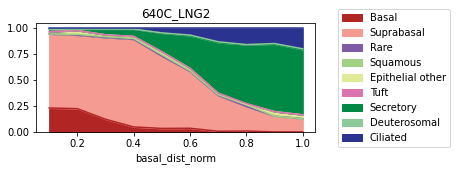

<Figure size 144x144 with 0 Axes>

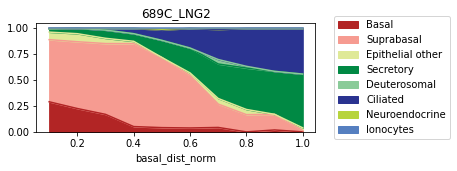

<Figure size 144x144 with 0 Axes>

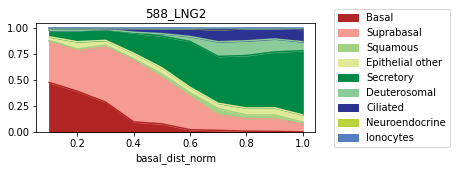

<Figure size 144x144 with 0 Axes>

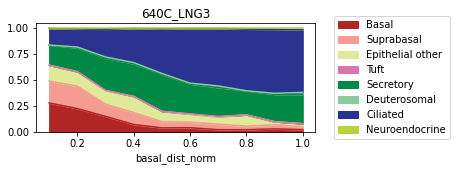

<Figure size 144x144 with 0 Axes>

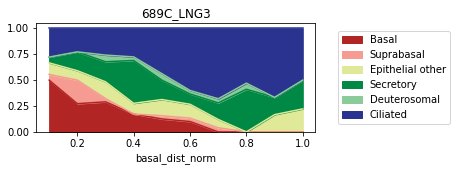

<Figure size 144x144 with 0 Axes>

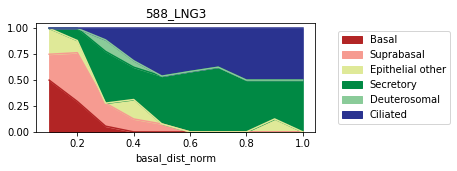

<Figure size 144x144 with 0 Axes>

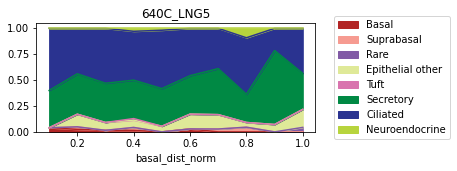

<Figure size 144x144 with 0 Axes>

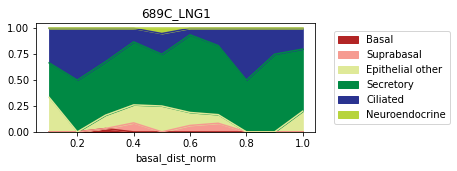

<Figure size 144x144 with 0 Axes>

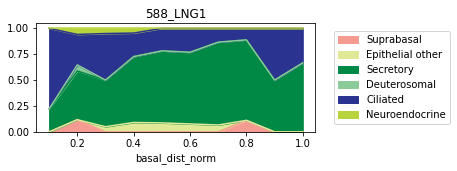

In [ ]:
cnt=0
for e in gg:
    import matplotlib
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    efilt=e.loc[e.index.isin(epith),:].transpose()
    efilt=efilt.div(efilt.sum(axis=1),axis=0)
    ordi=[e for e in epith if e in efilt.columns]
    efilt=efilt.loc[:,ordi]
    plt.figure(figsize=(2,2))
    efilt.iloc[1:,:].plot(kind='area',stacked=True,color=efilt.columns.map(coldict),figsize=(5,2))
    plt.title(nam[cnt])
    plt.legend(bbox_to_anchor=(1.5, 0.5),loc='right')
    #plt.savefig('/mnt/f/ISS/plots_for_publication/epithelium_analysis/basoluminal_'+str(nam[cnt])+'.pdf')
    plt.show()
    cnt=cnt+1

    

In [ ]:
for g in gg[0].index:
    out=pd.DataFrame(index=range(0,len(gg)),columns=gg[0].columns)
    tag=0
    try:
        for t in gg:
            out.loc[tag,:]=t.loc[g,:]
            tag=tag+1
        plt.figure()
        outdiv=out.div(out.sum(axis=1),axis=0)
        outdiv.index=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
        outdiv=outdiv.fillna(0)
        sns.clustermap(outdiv,col_cluster=False,row_cluster=False,figsize=(4,4))
        plt.title(g)
        plt.show()
    except:
        aa=2

# Comparison by expression

In [46]:
epith_expression

,640C_LNG2,640C_LNG3,640C_LNG5,689C_LNG1,689C_LNG2,689C_LNG3,588_LNG1,588_LNG2,588_LNG3
target,,,,,,,,,
A2M,86,162,147,115,58,1.0,93.0,105,13.0
ACAN,115,51,11,13,90,0.0,9.0,48,21.0
ACKR1,661,181,49,85,435,19.0,18.0,383,39.0
ACTA2,190,140,42,31,191,3.0,18.0,77,11.0
ADIRF,723,426,101,98,1073,28.0,59.0,511,45.0
...,...,...,...,...,...,...,...,...,...
TYROBP,213,93,44,15,138,2.0,19.0,17,5.0
VIM,73,118,14,7,81,1.0,4.0,6,3.0
VSIG2,69,84,10,8,65,2.0,4.0,37,4.0


In [51]:
extr=exxp.transpose()

In [85]:
sample=[i.split('_')[0] for i in extr.index]
region=[i.split('_')[1].replace('LNG5','LNG1') for i in extr.index]

In [86]:
extr['sample']=sample
extr['region']=region

In [ ]:
for g in extr.columns[:-2]:
    su=extr.loc[:,[g,'sample','region']]
    out=pd.DataFrame(index=su['sample'].unique(),columns=su['region'].unique())
    for ii in su.index:
        out.loc[su.loc[ii,'sample'],su.loc[ii,'region']]=su.loc[ii,g]
    out=out.loc[['640C','689C','588'],['LNG2','LNG3','LNG1']]
    fig,ax=plt.subplots(1,2,figsize=(6,2))
    out.transpose().plot(ax=ax[0])
    sns.heatmap(out.astype(float),ax=ax[1]) #### enable this to plot as heatmap instead
    plt.title(g)
    plt.show()

# combined plots

In [ ]:
for g in extr.columns[:-2]:
    out=pd.DataFrame(index=range(0,len(gg)),columns=gg[0].columns)
    tag=0
    try:
        for t in gg:
            out.loc[tag,:]=t.loc[g,:]
            tag=tag+1
        plt.figure()
        outdiv=out.div(out.sum(axis=1),axis=0)
        outdiv.index=['640C_LNG2','689C_LNG2','588_LNG2','640C_LNG3','689C_LNG3','588_LNG3',
                '640C_LNG5','689C_LNG1','588_LNG1']
        outdiv=outdiv.fillna(0)
        fig,ax=plt.subplots(1,2,figsize=(10,3))
        sns.heatmap(outdiv,ax=ax[0],cmap='Greens')
        ax[0].set_title('basal apical '+g)
        plt.title(g)
        ### distribution
        su=extr.loc[:,[g,'sample','region']]
        outs=pd.DataFrame(index=su['sample'].unique(),columns=su['region'].unique())
        for ii in su.index:
            outs.loc[su.loc[ii,'sample'],su.loc[ii,'region']]=su.loc[ii,g]
        outs=outs.loc[['640C','689C','588'],['LNG2','LNG3','LNG1']]
      #  out.transpose().plot(ax=ax[1])
        outs=outs.fillna(0)
        sns.heatmap(outs.astype(float),ax=ax[1],cmap='Blues') #### enable this to plot as heatmap instead
        plt.title('abundancy_change '+g)
        plt.show()

        
    except:
        aa=2

In [43]:
comm=expsort_640C_LNG5.index[expsort_640C_LNG5.index.isin(expsort_640C_LNG3.index)]
comm2=expsort_640C_LNG2.index[expsort_640C_LNG2.index.isin(comm)]

In [44]:
# note that all the plots are normalized by size of the epithelium. Obviously, 
#the thinkness of LNG2 is way larger than LNG5

In [ ]:

for g in comm2:
    lng5=expsort_640C_LNG5.loc[[g],:].transpose()
    lng2=expsort_640C_LNG2.loc[[g],:].transpose()
    lng3=expsort_640C_LNG3.loc[[g],:].transpose()
    locis=pd.concat([lng2,lng3,lng5],axis=1).fillna(0)
    locis.columns=['lng2','lng3','lng5']
    fig,axs=plt.subplots(1,2,figsize=(12,2))
    sns.heatmap(locis.transpose(),cmap='Blues',ax=axs[0])
    plt.title(g)
    plt.barh(exx.loc[g,::-1].index,exx.loc[g,::-1],color='#7ed2bb')
    plt.xlabel('relative frequency')
    plt.show()